In [1]:
# %%
import numpy as np
import scvelo as scv
import torch

from deepvelo.utils import velocity, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params(
    "scvelo", transparent=False
)  # for beautified visualization

%load_ext autoreload
%autoreload 2


Using backend: pytorch


# Load Data and preprocess
The Dentate Gyrus neurogenesis data from [La Manno et al. (2018)](https://doi.org/10.1038/s41586-018-0414-6).

In [2]:
adata = scv.datasets.dentategyrus_lamanno()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)


Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:21) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# DeepVelo

In [3]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
}
configs = update_dict(Constants.default_configs, configs)


The ratio of spliced reads is 75.4% (between 70% and 85%). Suggest using coeff_s 0.75.


In [4]:
# initial velocity
velocity(adata, mask_zero=False)
trainer = train(adata, configs)


computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([18213, 2000])


velo_mat shape: (18213, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


In [5]:
scv.tl.velocity_graph(adata, n_jobs=8)


computing velocity graph (using 8/8 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:01:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [6]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="clusters",
    legend_fontsize=9,
    dpi=150,  # increase dpi for higher resolution
)


computing velocity embedding
    finished (0:00:05) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


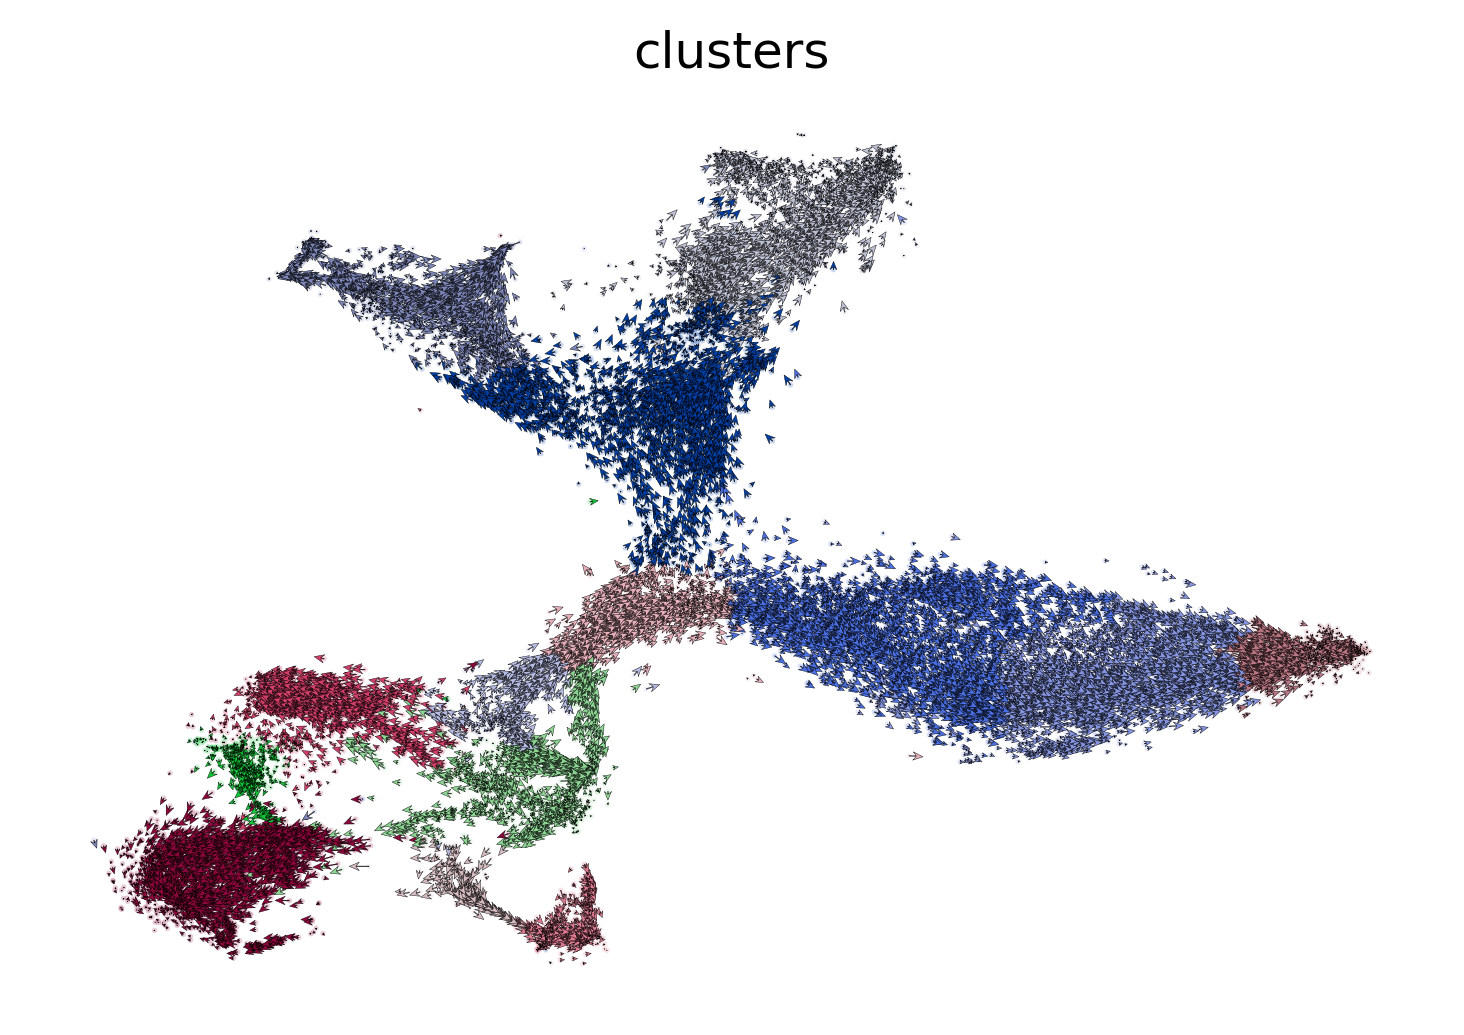

In [7]:
scv.pl.velocity_embedding(
    adata,
    basis="tsne",
    arrow_length=9,
    arrow_size=1.2,
    dpi=150,
)


In [8]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(
    adata,
    color="velocity_pseudotime",
    cmap="gnuplot",
    dpi=150,
)


computing terminal states
    identified 3 regions of root cells and 4 regions of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:04) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


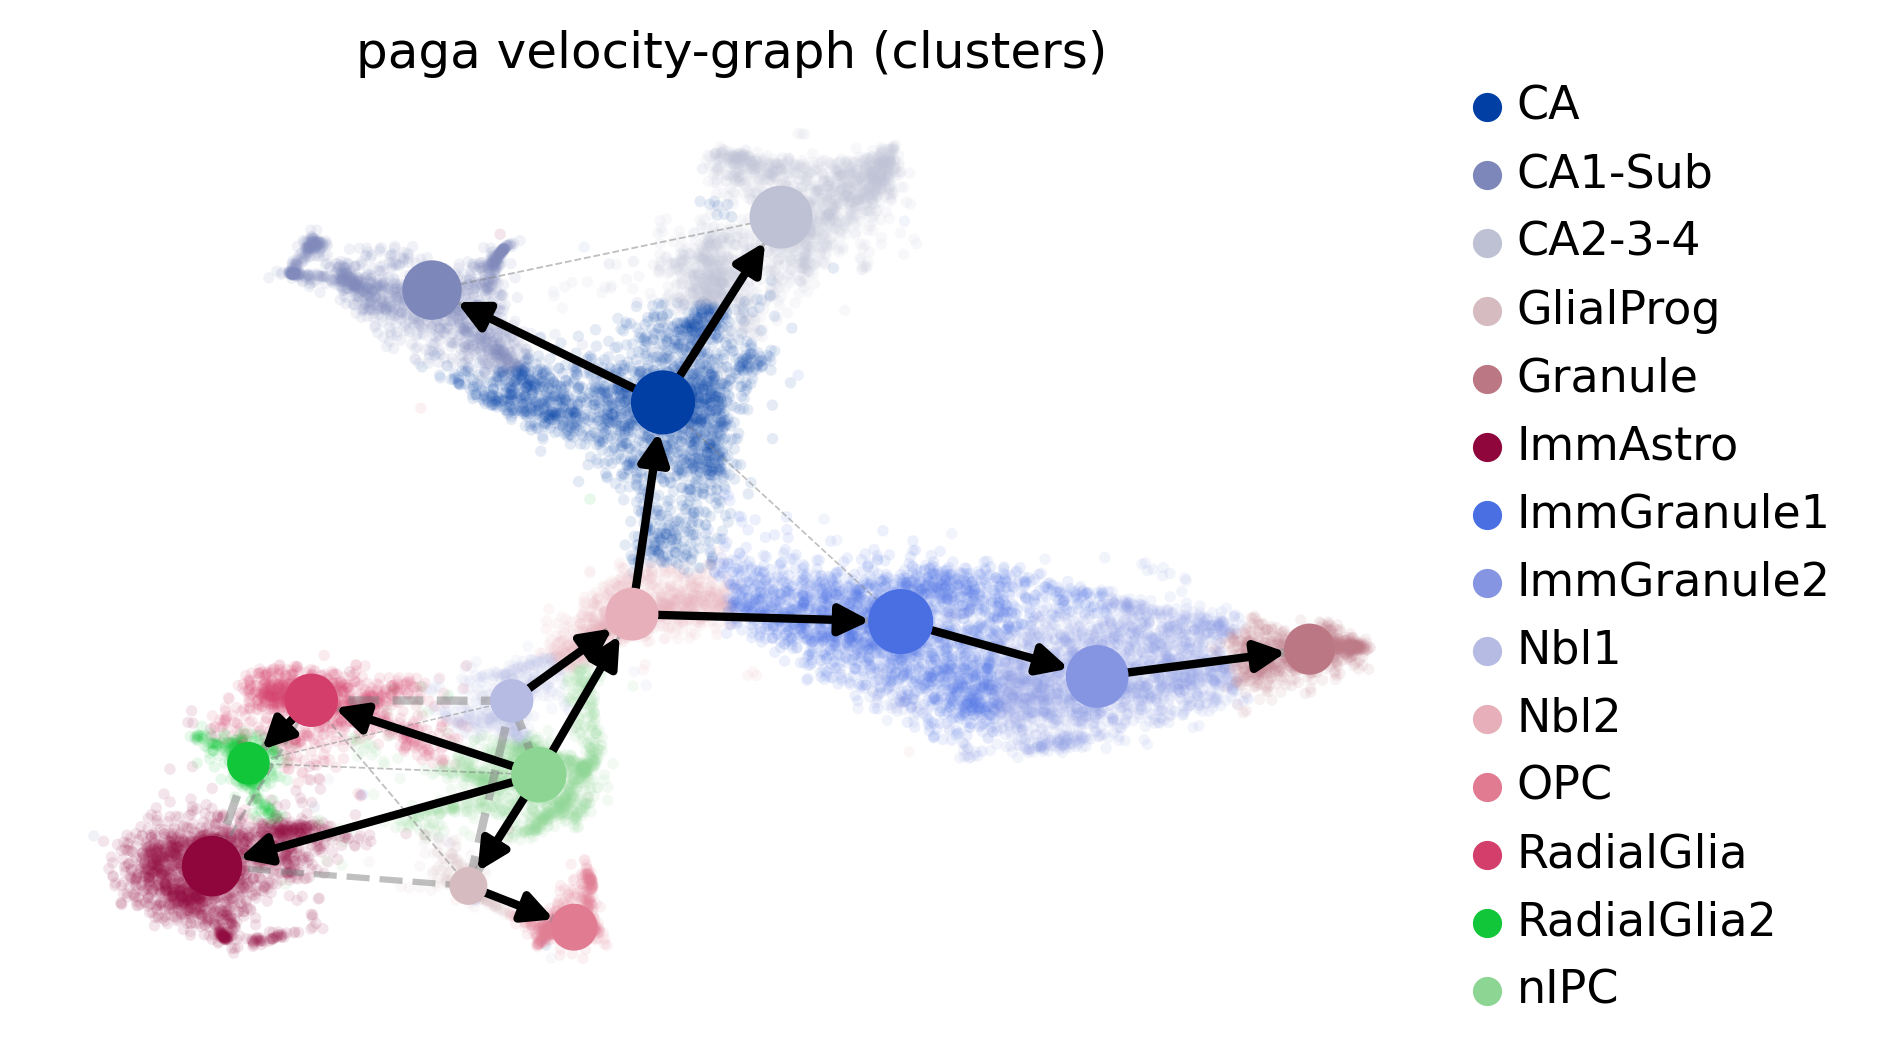

In [9]:
scv.tl.paga(adata, groups="clusters")
scv.pl.paga(
    adata,
    basis="tsne",
    size=30,
    alpha=0.1,
    min_edge_width=2,
    node_size_scale=1,
    dpi=150,
)


In [10]:
# save adata for next steps
deepvelo_adata = adata.copy()


# scVelo (dynamical)

In [11]:
adata = scv.datasets.dentategyrus_lamanno()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)


Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [12]:
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode="dynamical")


recovering dynamics (using 8/8 cores)


  0%|          | 0/1384 [00:00<?, ?gene/s]

    finished (0:09:42) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:32) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [13]:
scv.tl.velocity_graph(adata, n_jobs=8)


computing velocity graph (using 8/8 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:01:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:05) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


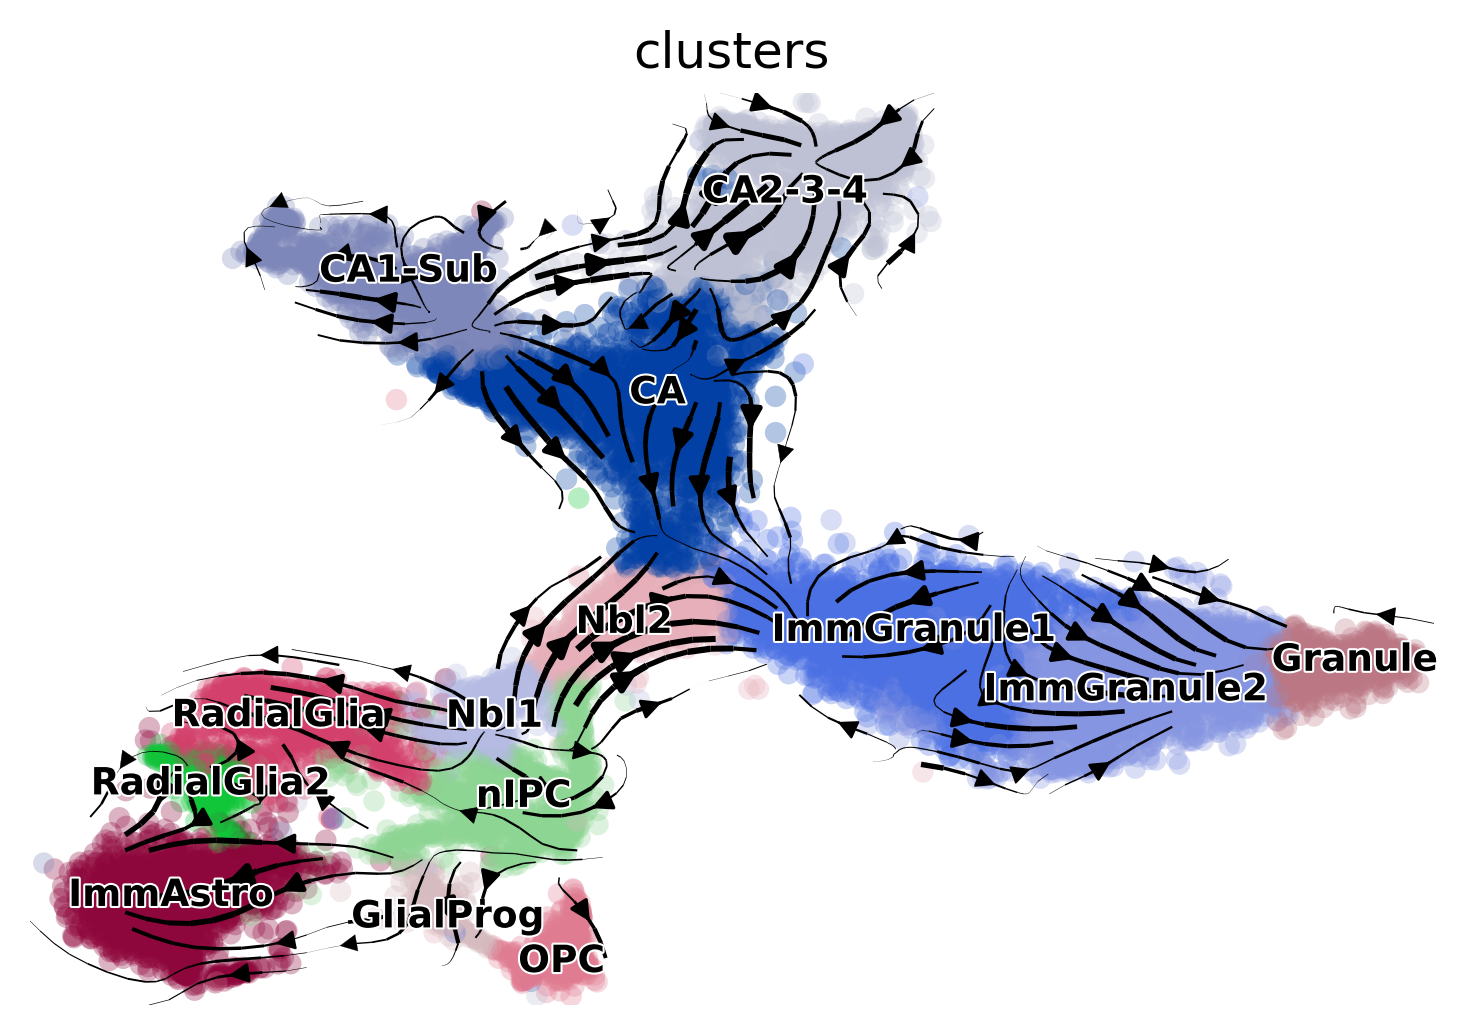

In [14]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="clusters",
    legend_fontsize=9,
    dpi=150,  # increase dpi for higher resolution
)


In [15]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(
    adata,
    color="velocity_pseudotime",
    cmap="gnuplot",
    dpi=150,
)


computing terminal states
    identified 3 regions of root cells and 4 regions of end points .
    finished (0:00:04) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:04) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


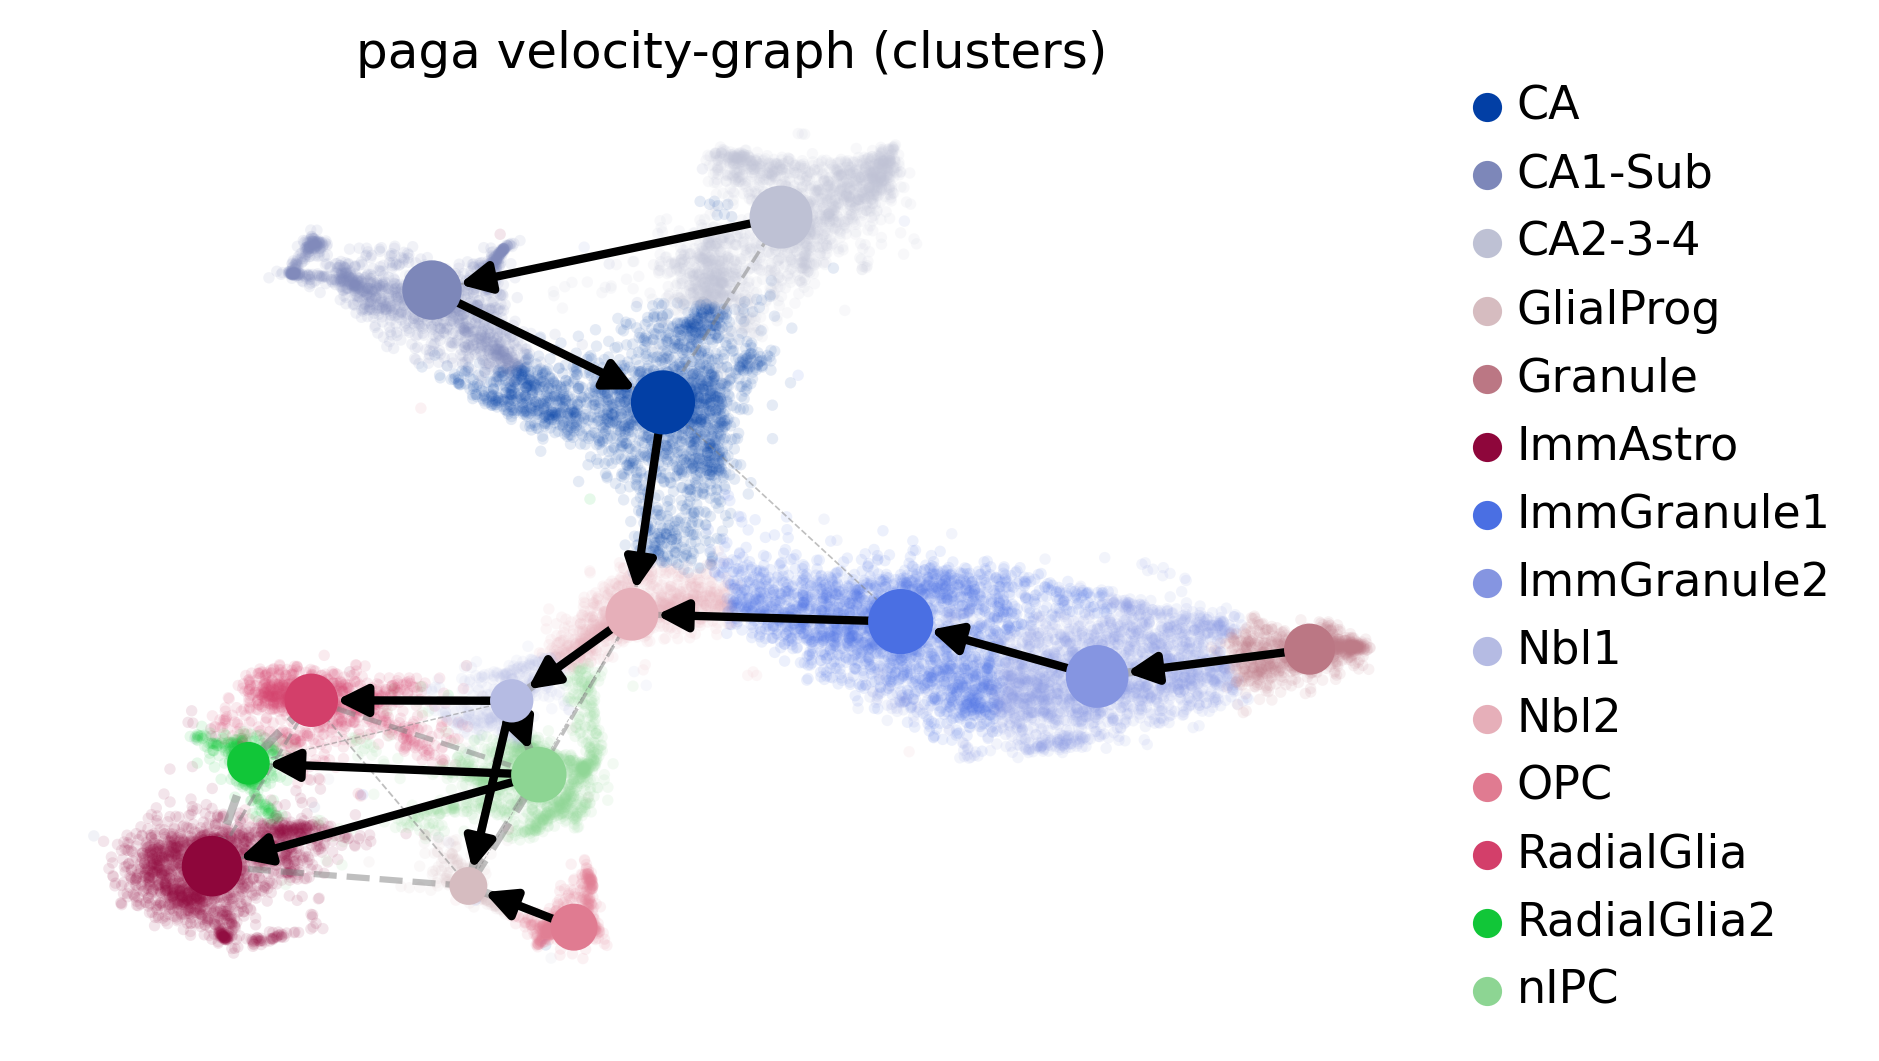

In [16]:
scv.tl.paga(adata, groups="clusters")
scv.pl.paga(
    adata,
    basis="tsne",
    size=30,
    alpha=0.1,
    min_edge_width=2,
    node_size_scale=1,
    dpi=150,
)


In [17]:
# save adata for next steps
dynamical_adata = adata.copy()


# Steady-state (stochastic)

In [18]:
adata = scv.datasets.dentategyrus_lamanno()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)


Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [19]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata, n_jobs=8)


computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 8/8 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:01:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [20]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="clusters",
    legend_fontsize=9,
    dpi=150,  # increase dpi for higher resolution
)


computing velocity embedding
    finished (0:00:05) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


computing terminal states
    identified 3 regions of root cells and 4 regions of end points .
    finished (0:00:04) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


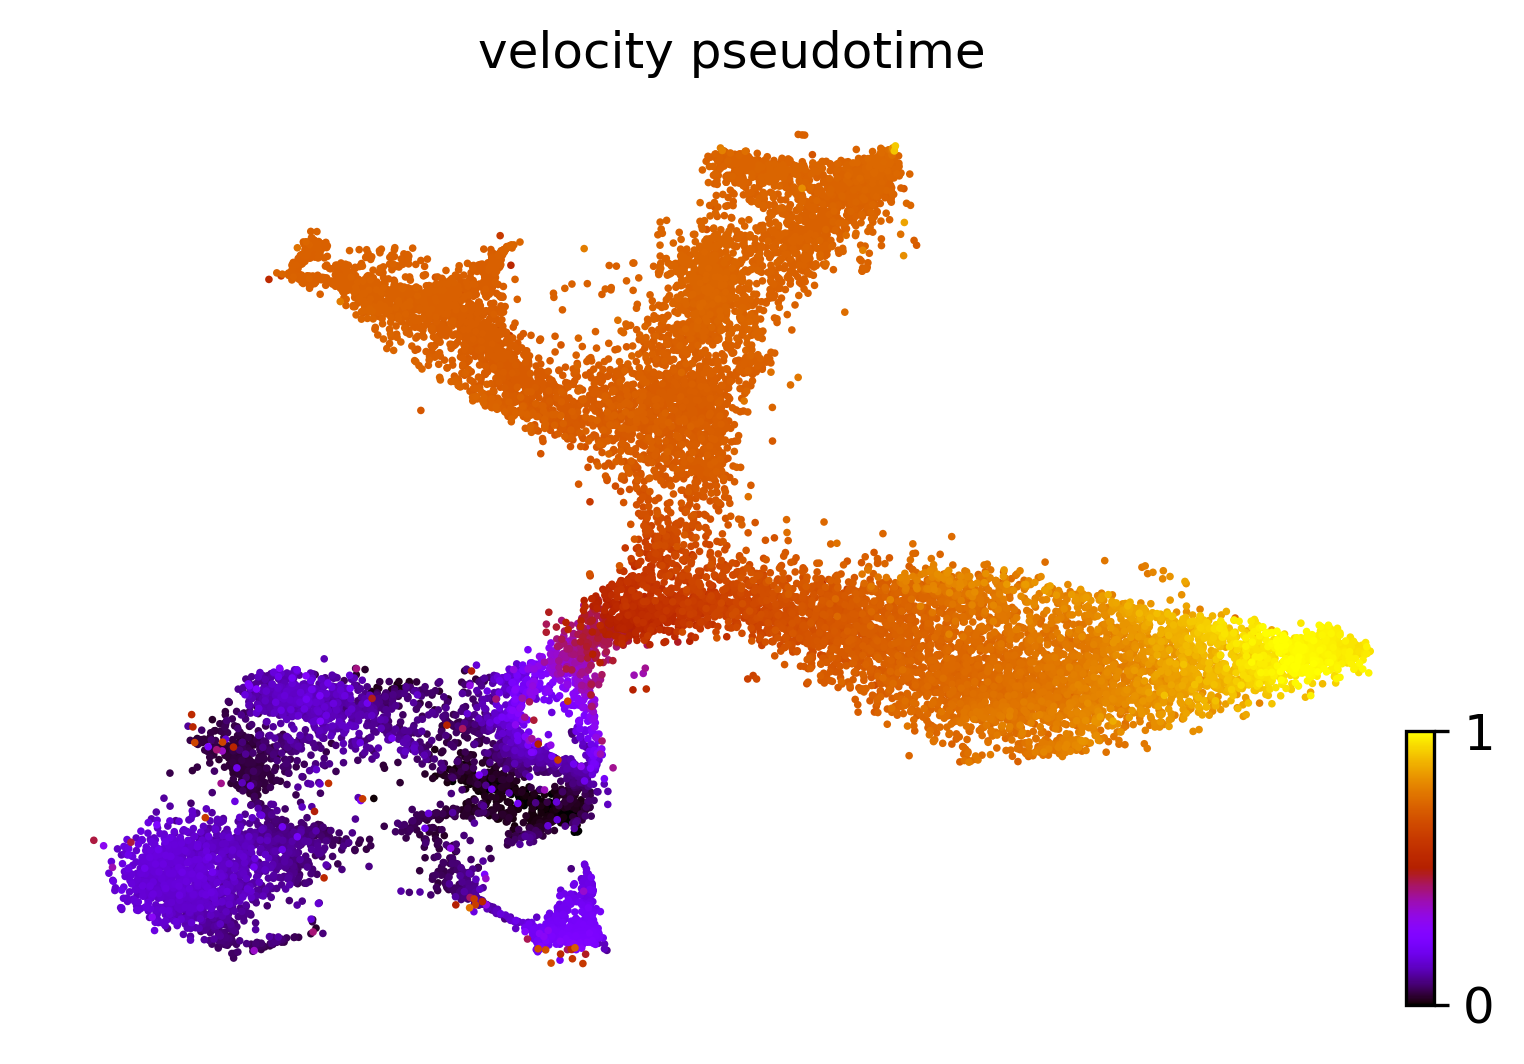

In [21]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(
    adata,
    color="velocity_pseudotime",
    cmap="gnuplot",
    dpi=150,
)


In [22]:
scv.tl.paga(adata, groups="clusters")
scv.pl.paga(
    adata,
    basis="tsne",
    size=30,
    alpha=0.1,
    min_edge_width=2,
    node_size_scale=1,
    dpi=150,
)


running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:05) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [23]:
# save adata for next steps
stochastic_adata = adata.copy()


# Compare consistency score

In [24]:
from deepvelo.utils.confidence import velocity_confidence
from deepvelo.utils.plot import statplot, compare_plot


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
DeepVelo mean score: 0.9370, std: 0.0336
Dynamical mean score: 0.8584, std: 0.0744
Stochastic mean score: 0.8744, std: 0.0919


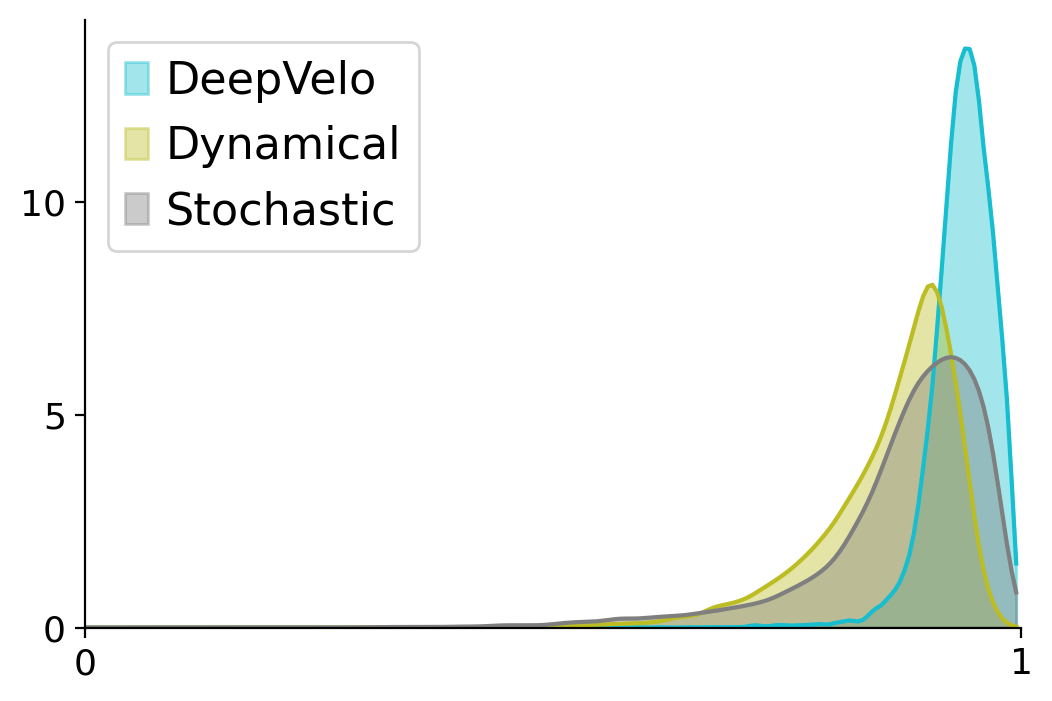

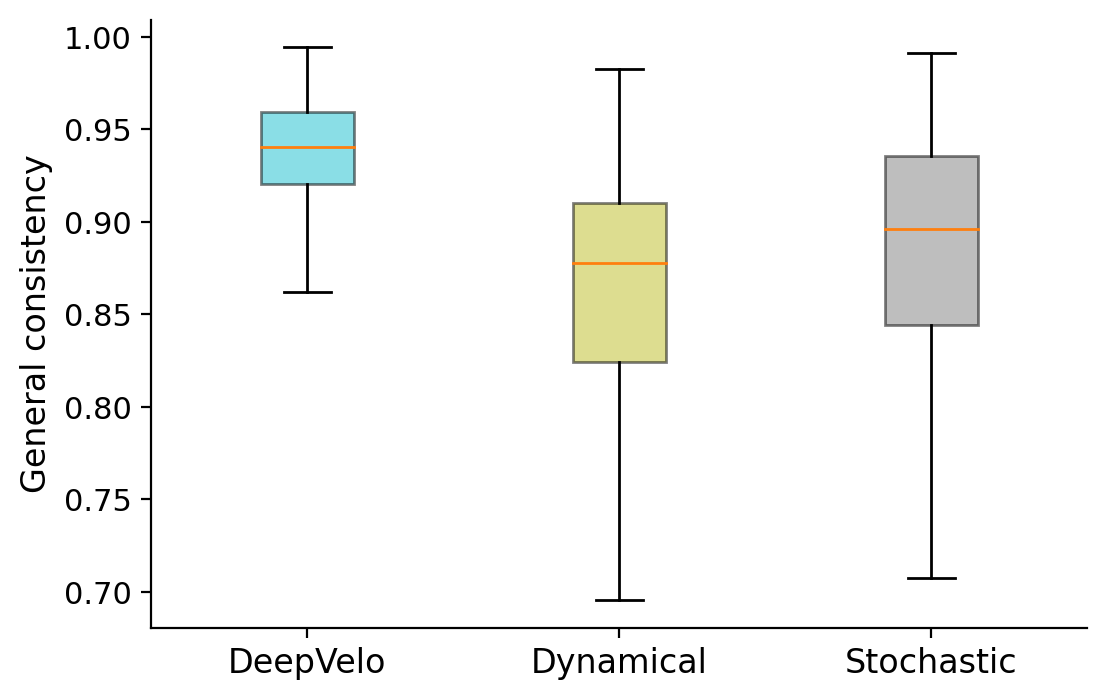

In [25]:
vkey = "velocity"
method = "cosine"
velocity_confidence(deepvelo_adata, vkey=vkey, method=method)
velocity_confidence(dynamical_adata, vkey=vkey, method=method)
velocity_confidence(stochastic_adata, vkey=vkey, method=method)
compare_plot(
    deepvelo_adata,
    dynamical_adata,
    stochastic_adata,
    labels=["DeepVelo", "Dynamical", "Stochastic"],
    method=method,
)


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
DeepVelo mean score: 0.7288, std: 0.0992
Dynamical mean score: 0.5901, std: 0.1926
Stochastic mean score: 0.6452, std: 0.1808


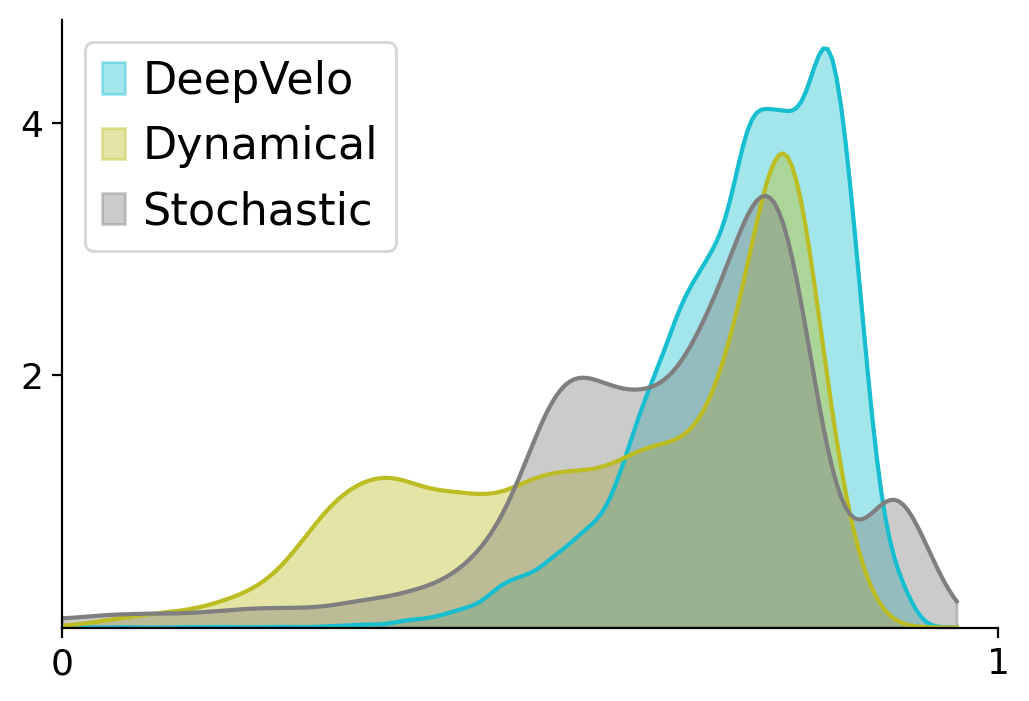

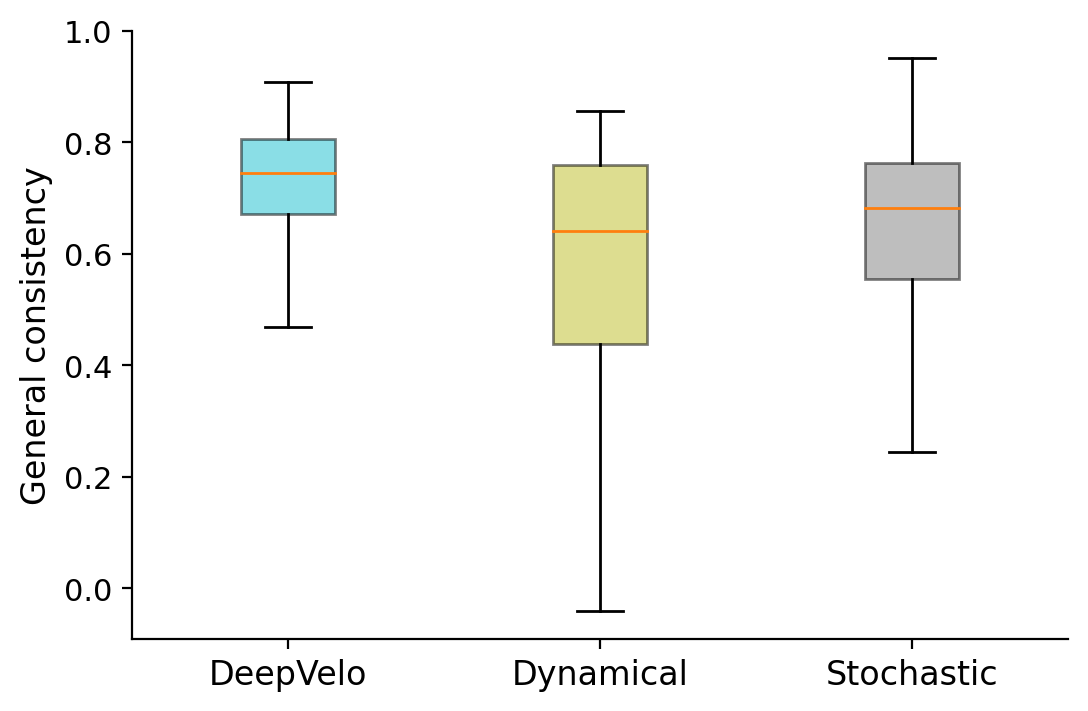

In [26]:
vkey = "velocity"
method = "cosine"
scope_key = "clusters"
# 3. cosine similarity, compute within Celltype
velocity_confidence(deepvelo_adata, vkey=vkey, method=method, scope_key=scope_key)
velocity_confidence(dynamical_adata, vkey=vkey, method=method, scope_key=scope_key)
velocity_confidence(stochastic_adata, vkey=vkey, method=method, scope_key=scope_key)
compare_plot(
    deepvelo_adata,
    dynamical_adata,
    stochastic_adata,
    labels=["DeepVelo", "Dynamical", "Stochastic"],
    method=method,
)
